# Latent Feature Extraction

## 1. Set up the Environment

In [1]:
!python -c "import monai" || pip install -q "monai-weekly[nibabel, tqdm]"

Traceback (most recent call last):
  File "<string>", line 1, in <module>
ModuleNotFoundError: No module named 'monai'
     |████████████████████████████████| 1.2 MB 18.6 MB/s 


In [2]:
import logging
import os
import sys
import shutil
import tempfile
import random
import time
import copy

import matplotlib.pyplot as plt
import torch
from torch.utils.tensorboard import SummaryWriter
import numpy as np
import pandas as pd

import monai
from monai.apps import download_and_extract
from monai.config import print_config
from monai.data import DataLoader, CacheDataset, partition_dataset_classes

from monai.transforms import (
    Compose,
    ScaleIntensityRanged,
    EnsureTyped,
    LoadImaged,
    AddChanneld,
    Orientationd,
    Resized,
    EnsureType,
    Activations,
    AsDiscrete
)

In [3]:
device = torch.device("cuda")

In [4]:
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

seed_everything(123)

## 2. Connect to Google Colab

In [5]:
from google.colab import drive
drive.mount('/content/drive',force_remount = True)

drive_dir = "/content/drive/My Drive"
mount_dir = os.path.join(drive_dir, "Colab Notebooks")
image_dir = os.path.join(mount_dir, "nnUNet_raw_data_base/nnUNet_raw_data/T2_test_data/imagesTs")
weights_dir = os.path.join(mount_dir, "pretrained_models/MedicalNet_resnet")
results_dir = os.path.join(drive_dir, "Test Data")

Mounted at /content/drive


## 3. Create Train and Validation Dataset

In [6]:
# specify transformations that are to be applied
transforms = Compose([
    LoadImaged(keys=["image"]),
    AddChanneld(keys=["image"]),
    Orientationd(keys=["image"], axcodes="PLI"),
    Resized(keys=["image"], spatial_size=(128, 128, 64)),
    ScaleIntensityRanged(keys=['image'], a_min=0, a_max=255, b_min=0.0, b_max=1.0, clip=True),
    EnsureTyped(keys=["image"])])

/usr/local/lib/python3.8/dist-packages/monai/utils/deprecate_utils.py:107: FutureWarning: <class 'monai.transforms.utility.array.AddChannel'>: Class `AddChannel` has been deprecated since version 0.8. please use MetaTensor data type and monai.transforms.EnsureChannelFirst instead.
  warn_deprecated(obj, msg, warning_category)


In [7]:
# Create labels
labels = np.concatenate((np.zeros(20, dtype='int64'), np.ones(20, dtype='int64')), axis=0)

# Get image paths
image_paths = [
  os.path.join(image_dir, img)
  for img in os.listdir(image_dir)
]

data = [{"image": i, "label": l} for i, l in zip(image_paths, labels)]

In [8]:
# create 80:20 data split
data_partition = partition_dataset_classes(data, labels.tolist(), shuffle=True, ratios=[0.8, 0.2])

# create data loader object
datasets = {x: CacheDataset(data=data_partition[x], transform=transforms) for x in [0, 1]}
dataloaders_dict = {x: DataLoader(datasets[x], batch_size=4, shuffle=True, num_workers=4) for x in [0, 1]}

# rename dict of data loader object
dataloaders_dict['train'] = dataloaders_dict.pop(0)
dataloaders_dict['val'] = dataloaders_dict.pop(1)

Loading dataset: 100%|██████████| 8/8 [00:06<00:00,  1.17it/s]
/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [18]:
def dataset_with_indices(cls):
    def __getitem__(self, index):
        data, target = cls.__getitem__(self, index)
        return data, target, index

    return type(cls.__name__, (cls,), {
        '__getitem__': __getitem__,
    })

In [ ]:
for img in range(0, 32):
  print(dataloaders_dict['train'].dataset[img]) # 4, 26, 15, 16, 22, 10, 37, 28, 23, 14, 27, 18, 29, 20, 31, 33, 34, 19, 21, 17, 13, 32, 39, 25, 2, 12, 35, 8, 7, 38, 3, 6

In [ ]:
for img in range(0, 8):
  print(dataloaders_dict['val'].dataset[img]) # 24, 1, 9, 5, 40, 30, 36, 11

## 4. Define Network Architecture

In [43]:
class ResNet50(torch.nn.Module):
    def __init__(self, num_classes, pretrained = False, features_extract = False):
        super().__init__()

        # load 3d ResNet
        self.model = monai.networks.nets.resnet50(spatial_dims=3, n_input_channels=1)
        if pretrained:
          model_dict = self.model.state_dict()

          # load pretrained MedicalNet weights
          weights_dict = torch.load(os.path.join(weights_dir, "resnet_50_23dataset.pth"))
          
          # rename modules in weight dict
          weights_dict = {k.replace('module.', ''): v for k, v in weights_dict['state_dict'].items()}

          # update model weights with pretrained weights
          model_dict.update(weights_dict)
          self.model.load_state_dict(model_dict)
        
        # freeze model weights
        if features_extract:
          conv_block = 0
          for child in self.model.children():
            conv_block += 1
            if conv_block < 8:
              for param in child.parameters():
                param.requires_grad = False
            elif conv_block == 8:
              layer = 0
              for children_of_child in child.children():
                layer += 1
                if layer < 3:
                  for param in children_of_child.parameters():
                    param.requires_grad = False

        # create custom fc layers
        num_ftrs = self.model.fc.in_features
        self.model.fc = torch.nn.Identity()

        self.features = torch.nn.Linear(num_ftrs, 128)
        self.classifier = torch.nn.Linear(128, num_classes)
    
    def forward(self, image):
        x = self.model(image)
        x = self.features(x)
        x = self.classifier(x)
        
        return x

## 5. Initialize the Network with Pretrained Weights

In [44]:
# Number of classes in the dataset
num_classes = 2

# Batch size for training (change depending on how much memory you have)
batch_size = 8

# Number of epochs to train for
num_epochs = 300

# Flag to indicate whether model should be initialized with pretrained weights
pretrained = True

# Flag to indicate whether only a set of weights should be updated. If False
# the entire model is finetuned
feature_extract = True

In [45]:
# Initialize the model for this run
model_ft = ResNet50(num_classes, pretrained, feature_extract)

# add model to GPU
model_ft = model_ft.to(device)

## 6. Specify Parameters that Should Be Finetuned  

In [46]:
# Gather the parameters to be optimized/updated in this run
params_to_update = model_ft.parameters()
print("Params to learn:")
if feature_extract:
    params_to_update = []
    for name,param in model_ft.named_parameters():
        if param.requires_grad == True:
            params_to_update.append(param)
            print("\t",name)
else:
    for name,param in model_ft.named_parameters():
        if param.requires_grad == True:
            print("\t",name)

Params to learn:
	 model.layer4.2.conv1.weight
	 model.layer4.2.bn1.weight
	 model.layer4.2.bn1.bias
	 model.layer4.2.conv2.weight
	 model.layer4.2.bn2.weight
	 model.layer4.2.bn2.bias
	 model.layer4.2.conv3.weight
	 model.layer4.2.bn3.weight
	 model.layer4.2.bn3.bias
	 features.weight
	 features.bias
	 classifier.weight
	 classifier.bias


## 7. Finetune the Network

In [47]:
# Specify the loss function
criterion = torch.nn.CrossEntropyLoss()

# Specify the learning rate
optimizer_ft = torch.optim.SGD(params_to_update, lr=0.01)

In [48]:
def train_model(model, dataloaders, criterion, optimizer, num_epochs=25, is_inception=False):
    since = time.time()

    train_loss_history = []
    val_acc_history = []

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    best_loss = 10000.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for batch_data in dataloaders[phase]:
                inputs, labels = batch_data["image"].to(device), batch_data["label"].to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    loss = criterion(outputs, labels)

                    _, preds = torch.max(outputs, 1)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            epoch_acc = running_corrects.double() / len(dataloaders[phase].dataset)

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc.item()))

            # safe training loss
            if phase == 'train':
                train_loss_history.append(epoch_loss)

            # deep copy the model
            if phase == 'val' and epoch_acc >= best_acc:
              if epoch_loss < best_loss:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
            if phase == 'val':
                val_acc_history.append(epoch_acc)

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc.item()))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model, val_acc_history, train_loss_history

In [49]:
# Train and evaluate
model_ft, acc_hist, loss_hist = train_model(model_ft, dataloaders_dict, criterion, optimizer_ft, num_epochs=num_epochs)

Epoch 0/299
----------


/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


train Loss: 0.7836 Acc: 0.5312
val Loss: 0.6934 Acc: 0.5000

Epoch 1/299
----------
train Loss: 0.7948 Acc: 0.4062
val Loss: 0.7009 Acc: 0.5000

Epoch 2/299
----------
train Loss: 0.7923 Acc: 0.5000
val Loss: 0.6933 Acc: 0.5000

Epoch 3/299
----------
train Loss: 0.8063 Acc: 0.4062
val Loss: 0.7132 Acc: 0.5000

Epoch 4/299
----------
train Loss: 0.7281 Acc: 0.5625
val Loss: 0.7020 Acc: 0.5000

Epoch 5/299
----------
train Loss: 0.7773 Acc: 0.4688
val Loss: 0.6916 Acc: 0.5000

Epoch 6/299
----------
train Loss: 0.7437 Acc: 0.3750
val Loss: 0.6905 Acc: 0.5000

Epoch 7/299
----------
train Loss: 0.7320 Acc: 0.4375
val Loss: 0.6925 Acc: 0.5000

Epoch 8/299
----------
train Loss: 0.7388 Acc: 0.3125
val Loss: 0.6850 Acc: 0.8750

Epoch 9/299
----------
train Loss: 0.7227 Acc: 0.5938
val Loss: 0.6844 Acc: 0.5000

Epoch 10/299
----------
train Loss: 0.7222 Acc: 0.5938
val Loss: 0.6738 Acc: 0.5000

Epoch 11/299
----------
train Loss: 0.7875 Acc: 0.4688
val Loss: 0.6745 Acc: 0.8750

Epoch 12/299


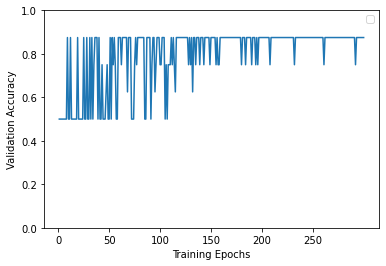

In [50]:
# Plot the training curves of validation accuracy vs. number of training epochs 
model_acc_hist = []
model_acc_hist = [epoch.cpu().numpy() for epoch in acc_hist]

#plt.title("Validation Accuracy vs. Number of Training Epochs")
plt.xlabel("Training Epochs")
plt.ylabel("Validation Accuracy")
plt.plot(range(1, num_epochs+1),model_acc_hist)
plt.ylim((0,1.))
plt.xticks(np.arange(0, num_epochs, 50))
plt.legend()

plt.savefig(os.path.join(results_dir, 'val_acc_hist.png'), dpi=300)

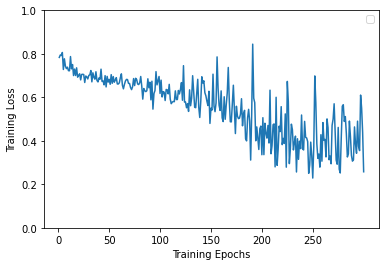

In [51]:
# Plot the training curves of validation accuracy vs. number of training epochs 
model_loss_hist = []
model_loss_hist = [epoch for epoch in loss_hist]

#plt.title("Training Loss vs. Number of Training Epochs")
plt.xlabel("Training Epochs")
plt.ylabel("Training Loss")
plt.plot(range(1, num_epochs+1), model_loss_hist)
plt.ylim((0,1.))
plt.xticks(np.arange(0, num_epochs, 50))
plt.legend()

plt.savefig(os.path.join(results_dir, 'train_loss_hist.png'), dpi=300)

## 8. Extract Latent Features from Finetuned Model

In [52]:
def get_features(name):
    def hook(model, input, output):
        features[name] = output.detach()
    return hook

In [53]:
# set hook at layer where features should be extracted
model_ft.features.register_forward_hook(get_features('feats'))

In [ ]:
# # placeholders
labels = []
pred = []
feats = []

# # placeholder for batch features
features = {}

# # loop through batches
for phase in ['train', 'val']:
  for batch_data in dataloaders_dict[phase]:
    # move to device
    inputs = batch_data["image"].to(device)
    targets = batch_data["label"].to(device)
       
    # forward pass [with feature extraction]
    preds = model_ft(inputs)
    
    # add feats and preds to lists
    labels.append(targets.detach().cpu().numpy())
    feats.append(features['feats'].cpu().numpy())

In [55]:
feats_ft = np.concatenate(feats)
feats_ft.shape # 128 features

(40, 128)

In [56]:
labels_ft = np.concatenate(labels)
labels_ft.shape

(40,)

In [ ]:
#deep_feats = np.squeeze(feats_ft, axis=3)
#deep_feats = np.squeeze(deep_feats, axis=2)
#deep_feats = np.squeeze(deep_feats, axis=2)

## 9. Write Feature Matrix to csv File

In [ ]:
# merge labels and features into a dataframe
labels = pd.DataFrame(labels_ft, columns=['HCC'])
deep_feats = pd.DataFrame(feats_ft, 
                          columns = ["var%d" % (i + 1) 
                          for i in range(feats_ft.shape[1])])

deep_feats = pd.concat([labels.reset_index(drop=True), deep_feats], axis=1)

# write dataframe to csv
deep_feats.to_csv(os.path.join(results_dir, 'DeepFeaturesNew.csv'), index=False, header=True, sep=',')